## Getting normal data

Tickers we should use:

The 6 companies we have selected:
- BRK-A: class A stock for BRK, the investing firm
- BRK-B: class B
- ORCL: oracle
- META: meta
- KO: coca-cola
- IBM: IBM
- TSLA: Tesla

Over all market prices:
-  ^GSPC: S & P 500, indicates the overall market in america
-  ^IXIC: NASDAQ, geared towards tech companies.
Currently using both as we have a domination of tech comapanies but different ones like coca-cola and BRK in our stocks list. If we see any issues like mutlicollinearity, we will remove NASDAQ

Sectors:

- XLF: Financials Select Sector SPDR Fund (For Berkshire Hathaway)
- XLC: Communication Services Select Sector SPDR Fund (For Meta)
- XLY: Consumer Discretionary Select Sector SPDR Fund (For Tesla)
- XLK: Technology Select Sector SPDR Fund (For IBM and Oracle)
- XLP: Consumer Staples Select Sector SPDR Fund (For Coca-Cola)

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

tickers = [ "BRK-A","BRK-B", "ORCL", "META", "TSLA", "KO", "IBM", '^GSPC', "^IXIC", "XLF", "XLC", "XLY", "XLK", "XLP"]

short_data = yf.download(
    tickers=tickers,
    period = "1mo",
    interval= "2m"
)

[*********************100%***********************]  14 of 14 completed


In [156]:
medium_data = yf.download(
    tickers=tickers,
    period = "2y",
    interval= "1h"
)

[*********************100%***********************]  14 of 14 completed


In [252]:
long_data = yf.download(
    tickers=tickers,
    period = "max",
    interval= "1d"
)

[*********************100%***********************]  14 of 14 completed


## Data Cleaning

In [255]:
def general_description(data):
    """
    Generates and prints general descriptive statistics and information for data cleaning purposes.

    This function provides essential details about the DataFrame, such as head of the DataFrame, missing values,
    summary statistics, number of duplicates (if any), number of columns with erroneous negative values (if any) and skewness measure, to aid in data cleaning and preprocessing steps.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame that will be analyzed for general description. 

    Returns
    -------
    None
        This function prints various statistics and information.
    """
    print("Head of the data:\n\t", data.head())
    
    print("\n\nInformation on data types:\n\t")
    print(data.info())

    print("\n\nData shape:\n\t", data.shape)
    
    # getting the first level columns
    columns = {column[0] for column in data.columns}

    # iterating over the first level of columns so that the description is visible for all data
    for column in columns:
        print(f"\n\nDescription of {column} column:\n\t", data.describe()[[column]])
    
    # looking at the number of missing values for each column combination
    for column in columns:
        print(f"\n\nMissing values count on {column} column:\n\t", data[[column]].isna().sum())
    
    number_of_duplicates = data.duplicated().sum()
    print("\n\nNumber of duplicates:\n\t", number_of_duplicates)

    # calculating skewness and seeing how many rows are highly skewed
    number_skewed_columns = (np.abs(data.skew()) > 1).sum()
    print("\n\nNumber of skewed columns:\n\t", number_skewed_columns)

    # checking to see if there are any any unrealistic negative values
    number_of_negatives = ((data < 0).sum() != 0).sum()
    print("\n\nNumber of columns with negative values:\n\t", number_of_negatives)

def boxplot(data):
    """
    Generates and displays box plots for a DataFrame with a two-level column index.

    This function creates box plots for each of the columns in the input DataFrame, assuming that the DataFrame 
    has a multi-level (two-level) column index. It is useful for identifying outliers within each subgroup of 
    the multi-level column structure.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame with a two-level column index. Each column in the DataFrame will be visualized 
        as a separate box plot.

    Returns
    -------
    None
        This function generates and displays box plots for the data but does not return any values.
    """

    scaler = MinMaxScaler(feature_range=(0, 1))
    columns = {column[0] for column in data.columns}

    # initiating a separate plot for each of the first level columns
    for column in columns:
        # scaling data for clearer visualization
        scaled_data_numpy = scaler.fit_transform(data[column])
        scaled_data = pd.DataFrame(scaled_data_numpy, columns=scaler.get_feature_names_out())
        sns.boxplot(data=scaled_data)
        plt.title(column)
        plt.xticks(rotation=45)
        plt.show()

def get_columns_outliers(data):
    """
    Identifies and returns the column names that contain outliers in the input DataFrame.

    This function detects columns that have outliers based on inter-quartile range (IQR). 
    It returns a list of columns where outliers are detected.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing the data to be analyzed for outliers.

    Returns
    -------
    outlier_columns : list
        A list of column names (or multi-level column combinations if the DataFrame has a multi-level column index)
        that contain outliers.

    Notes
    -----
    The function assumes that outliers are defined as values beyond a certain threshold (1.5*IQR).
    """

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)

    # seeing if a column has outliers or not
    # we only want to winsorize columns with outliers
    outlier_data = ((data < lower) | (data > upper)).sum() != 0
    
    # getting a list of columns with outliers in them
    outlier_columns = outlier_data[outlier_data==True].index
    print(outlier_columns)
    
    return outlier_columns
    


### Short range data cleaning

In [115]:
general_description(short_data)

Head of the data:
	 Price                            Close                                     \
Ticker                           BRK-A       BRK-B         IBM         KO   
Datetime                                                                    
2024-12-02 14:30:00+00:00  724618.7500  482.850006  227.350006  64.059998   
2024-12-02 14:32:00+00:00  724275.1250  483.010010  227.470001  63.980000   
2024-12-02 14:34:00+00:00  723240.0000  482.234985  227.199997  63.810001   
2024-12-02 14:36:00+00:00  722215.5625  481.625000  226.320007  63.610001   
2024-12-02 14:38:00+00:00  722101.0000  481.200012  226.320007  63.544998   

Price                                                                     \
Ticker                           META        ORCL        TSLA        XLC   
Datetime                                                                   
2024-12-02 14:30:00+00:00  579.929993  181.020004  355.570007  98.559998   
2024-12-02 14:32:00+00:00  582.830017  183.119400  358.1799

In [13]:
# using forward fill
short_data.ffill(inplace=True)

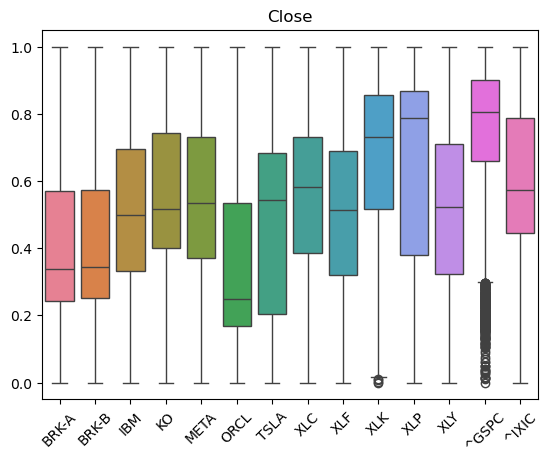

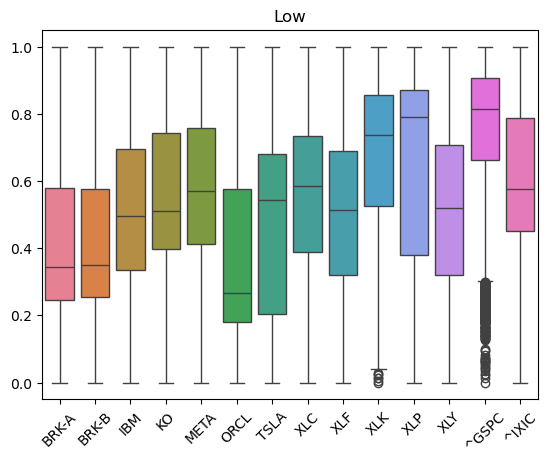

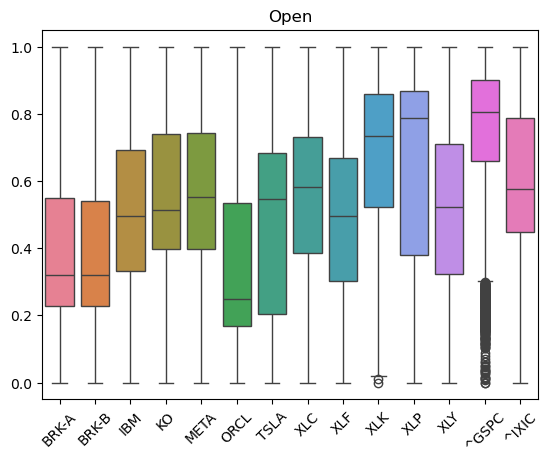

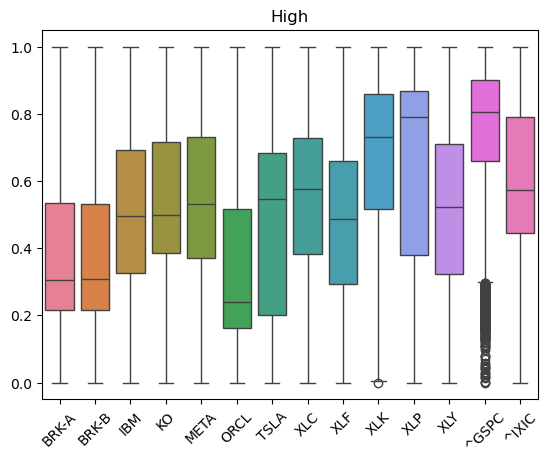

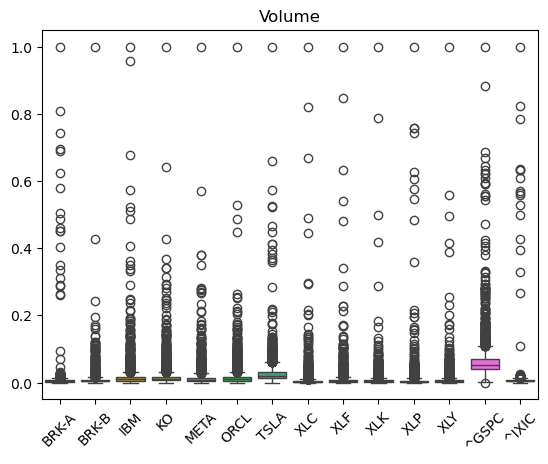

In [ ]:
boxplot(short_data)

In [77]:
# getting a list of columns with outliers in them
outlier_columns = get_columns_outliers(short_data)
print(outlier_columns)

MultiIndex([( 'Close',   'XLK'),
            ( 'Close', '^GSPC'),
            (  'High',   'XLK'),
            (  'High', '^GSPC'),
            (   'Low',   'XLK'),
            (   'Low', '^GSPC'),
            (  'Open',   'XLK'),
            (  'Open', '^GSPC'),
            ('Volume', 'BRK-A'),
            ('Volume', 'BRK-B'),
            ('Volume',   'IBM'),
            ('Volume',    'KO'),
            ('Volume',  'META'),
            ('Volume',  'ORCL'),
            ('Volume',  'TSLA'),
            ('Volume',   'XLC'),
            ('Volume',   'XLF'),
            ('Volume',   'XLK'),
            ('Volume',   'XLP'),
            ('Volume',   'XLY'),
            ('Volume', '^GSPC'),
            ('Volume', '^IXIC')],
           names=['Price', 'Ticker'])


In [98]:
# using Winsorization to deal with outliers
for column in outlier_columns:
        if (column[1] == "XLK") or (column[0] == "Volume"): # lower outliers for these columns are not a lot and don't need heavy clipping
                lower = short_data[column].quantile(0.002)
        else:
                lower = short_data[column].quantile(0.09) # lower outliers for "^GSPC" need heavy clipping
        
        if column[0] == "Volume": # upper outliers have only be seen in the trading volumes
                upper = short_data[column].quantile(0.89)
        else:
                upper = short_data[column].quantile(0.99999995)
        short_data[column] = short_data[column].clip(lower=lower, upper=upper)

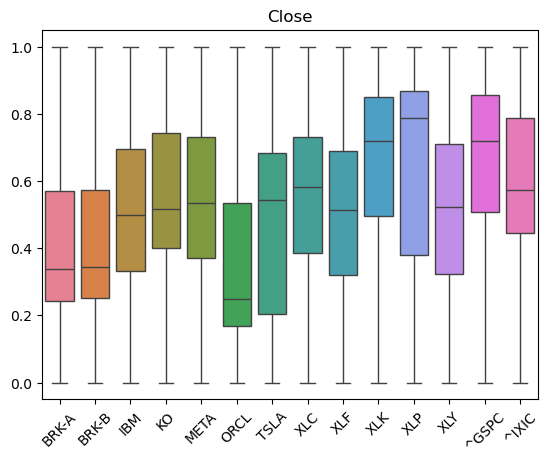

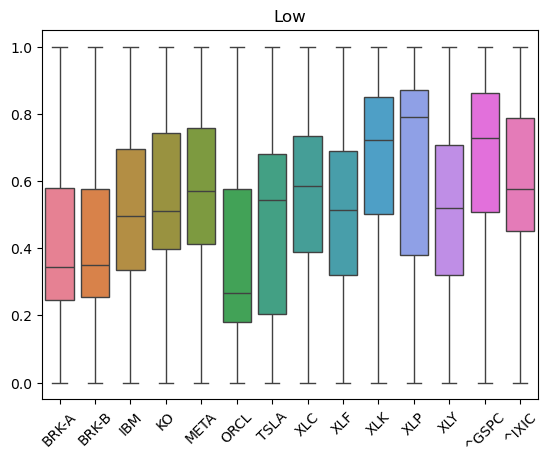

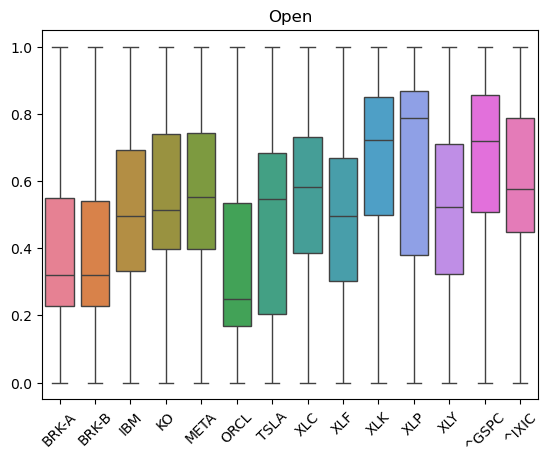

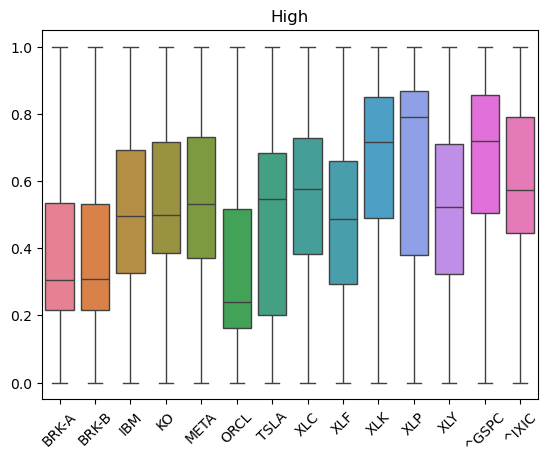

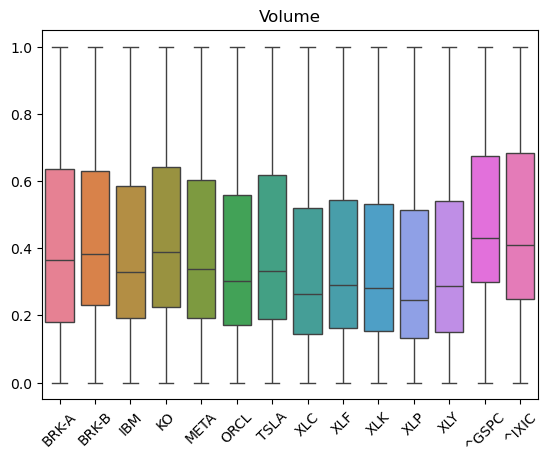

In [130]:
boxplot(short_data)

### Medium range data cleaning

In [157]:
general_description(medium_data)

Head of the data:
	 Price                            Close                                     \
Ticker                           BRK-A       BRK-B         IBM         KO   
Datetime                                                                    
2022-12-30 18:30:00+00:00  464950.0000  306.183594  139.830002  63.250000   
2022-12-30 19:30:00+00:00  465490.0000  307.220001  139.940002  63.404999   
2022-12-30 20:30:00+00:00  467587.0000  308.980011  140.880005  63.619999   
2023-01-03 14:30:00+00:00  469249.6250  310.279999  141.169998  62.970001   
2023-01-03 15:30:00+00:00  467428.4375  309.111603  140.895004  62.505001   

Price                                                                    \
Ticker                           META       ORCL        TSLA        XLC   
Datetime                                                                  
2022-12-30 18:30:00+00:00  118.885002  81.160004  121.459999  47.459999   
2022-12-30 19:30:00+00:00  119.500000  81.580002  122.361702  4

In [158]:
medium_data.ffill(inplace=True)

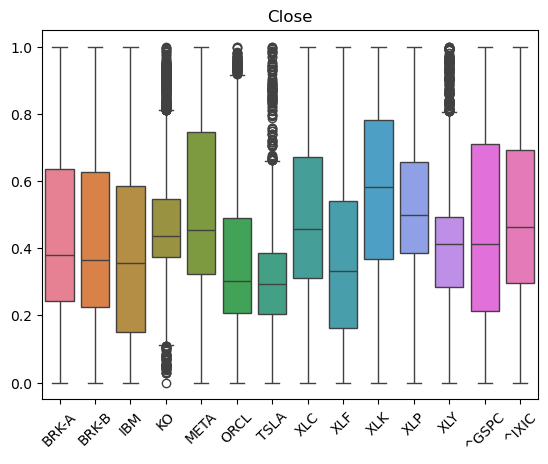

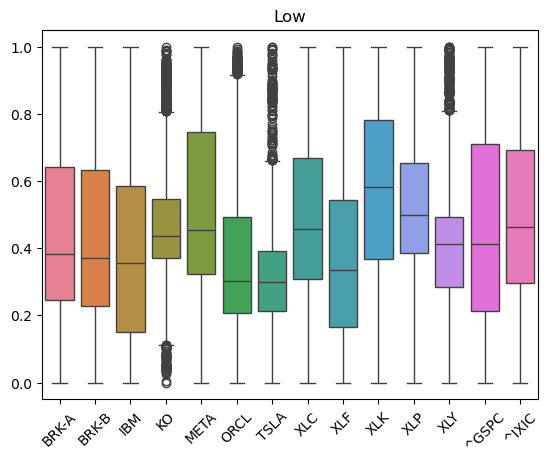

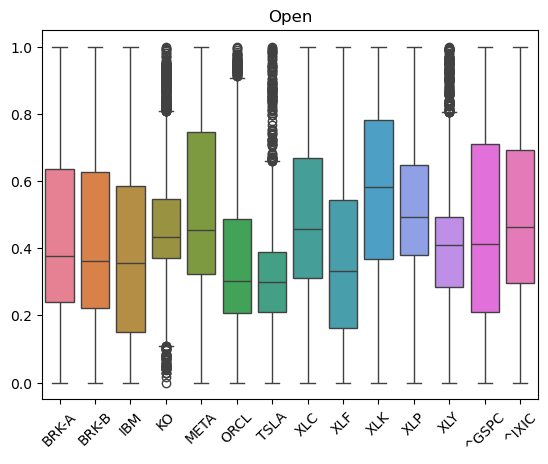

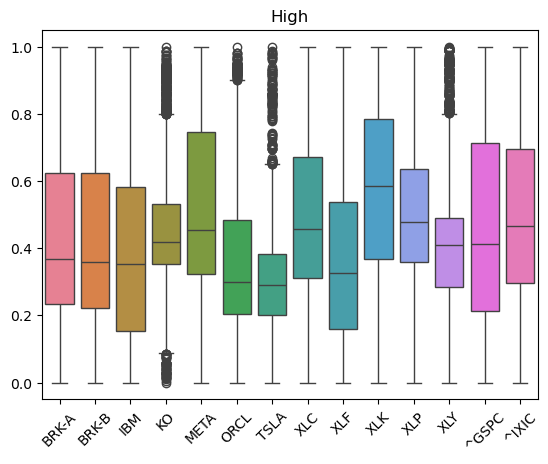

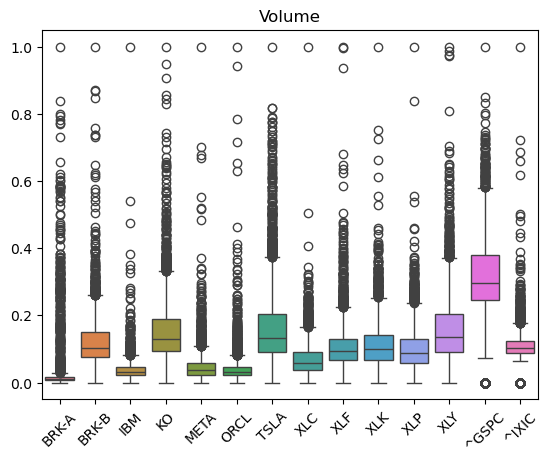

In [159]:
boxplot(medium_data)

In [160]:
outlier_columns = get_columns_outliers(medium_data)
print(outlier_columns)

MultiIndex([( 'Close',    'KO'),
            ( 'Close',  'ORCL'),
            ( 'Close',  'TSLA'),
            ( 'Close',   'XLY'),
            (  'High',    'KO'),
            (  'High',  'ORCL'),
            (  'High',  'TSLA'),
            (  'High',   'XLY'),
            (   'Low',    'KO'),
            (   'Low',  'ORCL'),
            (   'Low',  'TSLA'),
            (   'Low',   'XLY'),
            (  'Open',    'KO'),
            (  'Open',  'ORCL'),
            (  'Open',  'TSLA'),
            (  'Open',   'XLY'),
            ('Volume', 'BRK-A'),
            ('Volume', 'BRK-B'),
            ('Volume',   'IBM'),
            ('Volume',    'KO'),
            ('Volume',  'META'),
            ('Volume',  'ORCL'),
            ('Volume',  'TSLA'),
            ('Volume',   'XLC'),
            ('Volume',   'XLF'),
            ('Volume',   'XLK'),
            ('Volume',   'XLP'),
            ('Volume',   'XLY'),
            ('Volume', '^GSPC'),
            ('Volume', '^IXIC')],
         

In [249]:
# using Winsorization to deal with outliers
for column in outlier_columns:
        if column[1] == "KO":  # lower outliers for "KO" is significant
                lower = medium_data[column].quantile(0.02)
        elif column[1] in ["^GSPC", "^IXIC"]: # distant outliers here
                lower = medium_data[column].quantile(0.14)
        else:
                lower = medium_data[column].quantile(0.00000001) # lower outliers for the rest is not a lot
        
        if column[0] == "Volume": # upper outliers are highly significant in the trading volumes
                if column[1] == "BRK-A": # so many upper outliers
                        upper = medium_data[column].quantile(0.87)
                else:
                        upper = medium_data[column].quantile(0.93)
        elif column[1] == "KO": # different upper outlier
                upper = medium_data[column].quantile(0.91)
        else:
                upper = medium_data[column].quantile(0.94)
        medium_data[column] = medium_data[column].clip(lower=lower, upper=upper)

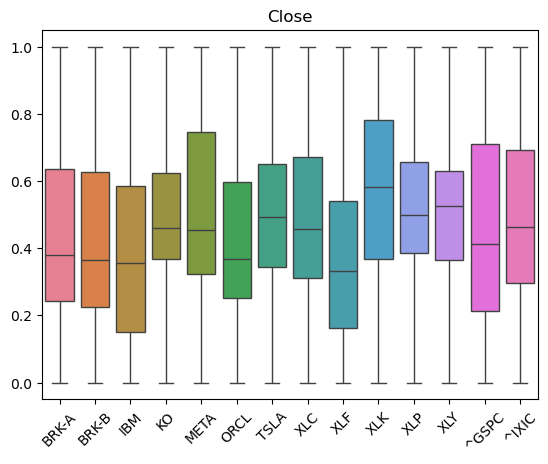

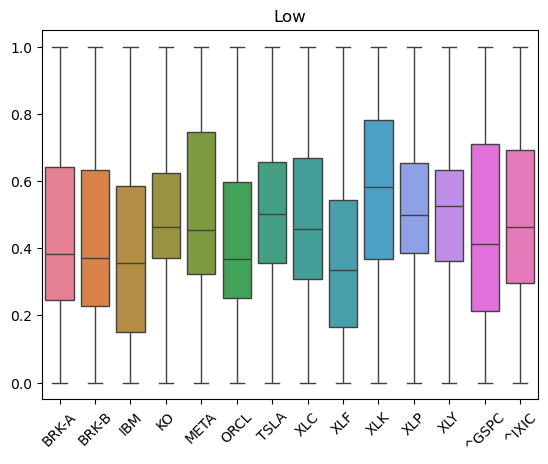

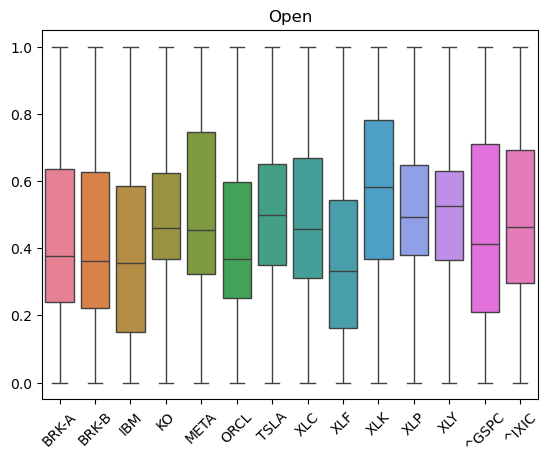

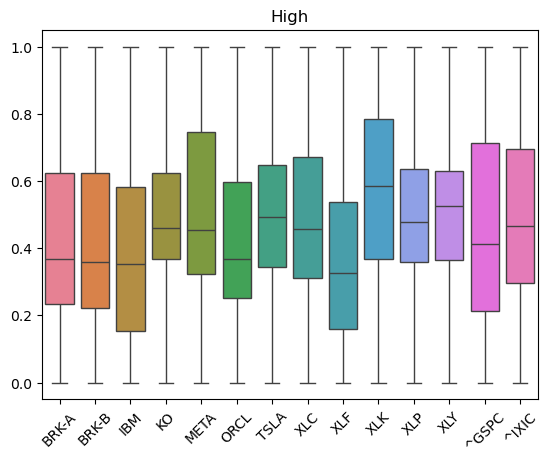

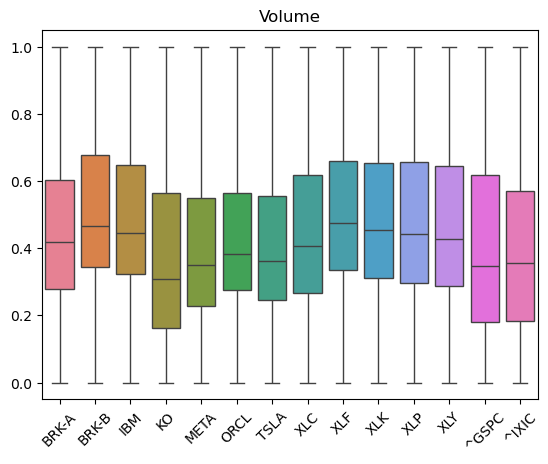

In [250]:
# visualizing effect of Winsorization
boxplot(medium_data)

### Data cleaning for long range data

In [253]:
general_description(long_data)

Head of the data:
	 Price      Close                                           ... Volume       \
Ticker     BRK-A BRK-B IBM  KO META ORCL TSLA XLC XLF XLK  ...   META ORCL   
Date                                                       ...               
1927-12-30   NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN  ...    NaN  NaN   
1928-01-03   NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN  ...    NaN  NaN   
1928-01-04   NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN  ...    NaN  NaN   
1928-01-05   NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN  ...    NaN  NaN   
1928-01-06   NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN  ...    NaN  NaN   

Price                                            
Ticker     TSLA XLC XLF XLK XLP XLY ^GSPC ^IXIC  
Date                                             
1927-12-30  NaN NaN NaN NaN NaN NaN     0   NaN  
1928-01-03  NaN NaN NaN NaN NaN NaN     0   NaN  
1928-01-04  NaN NaN NaN NaN NaN NaN     0   NaN  
1928-01-05  NaN NaN NaN NaN NaN NaN     0   NaN  
1928-

## Accounting for Holidays(also part of feature engineering)... create a function

Stock prices change when they are near holidays. specially in our model's case, stocks of companies like coca-cola and Meta are affected by the days being near holidays. Some of these effects last from a day to about a week before and after a holiday. As we are dealing with different ranges fro periods of our data, we have choses as the range with in 5 days before or after holidays to be the deciding range.

In [123]:
from workalendar.usa import UnitedStates

calendar = UnitedStates()
holidays = list()
for year in range(short_data.index.min().year, short_data.index.max().year + 2): #+2 to consider the days before next year's christmas
    holidays.extend(calendar.holidays(year))
holidays = np.array([holiday[0] for holiday in holidays])
holidays

array([datetime.date(2024, 1, 1), datetime.date(2024, 1, 15),
       datetime.date(2024, 2, 19), datetime.date(2024, 5, 27),
       datetime.date(2024, 7, 4), datetime.date(2024, 9, 2),
       datetime.date(2024, 10, 14), datetime.date(2024, 11, 11),
       datetime.date(2024, 11, 28), datetime.date(2024, 12, 25),
       datetime.date(2025, 1, 1), datetime.date(2025, 1, 20),
       datetime.date(2025, 2, 17), datetime.date(2025, 5, 26),
       datetime.date(2025, 7, 4), datetime.date(2025, 9, 1),
       datetime.date(2025, 10, 13), datetime.date(2025, 11, 11),
       datetime.date(2025, 11, 27), datetime.date(2025, 12, 25)],
      dtype=object)

In [124]:
short_data.tail()

Price                            Close                                      \
Ticker                           BRK-A       BRK-B        XLF        ^GSPC   
Datetime                                                                     
2024-12-27 20:50:00+00:00  686718.0000  457.929993  48.794998  5975.830078   
2024-12-27 20:52:00+00:00  686833.7500  457.980011  48.794998  5976.430176   
2024-12-27 20:54:00+00:00  685867.4375  457.350006  48.720001  5967.669922   
2024-12-27 20:56:00+00:00  685967.0000  457.540009  48.744999  5971.020020   
2024-12-27 20:58:00+00:00  684908.5000  456.899994  48.740002  5972.250000   

Price                           High                                      \
Ticker                         BRK-A       BRK-B        XLF        ^GSPC   
Datetime                                                                   
2024-12-27 20:50:00+00:00  686763.75  457.929993  48.799999  5976.390137   
2024-12-27 20:52:00+00:00  686833.75  458.029999  48.799999  5977.470215   
2024-12-27 20:54:00+00:00  686760.25  458.119995  48.794998  5976.470215   
2024-12-27 20:56:00+00:00  685967.00  457.690002  48.757500  5972.189941   
2024-12-27 20:58:00+00:00  686090.00  457.570007  48.759998  5972.740234   

Price                           Low                                      \
Ticker                        BRK-A       BRK-B        XLF        ^GSPC   
Datetime                                                                  
2024-12-27 20:50:00+00:00  685000.0  456.529999  48.660000  5960.049805   
2024-12-27 20:52:00+00:00  686782.0  457.489990  48.740002  5971.290039   
2024-12-27 20:54:00+00:00  685749.0  457.119995  48.709999  5965.830078   
2024-12-27 20:56:00+00:00  685967.0  457.230011  48.700001  5966.009766   
2024-12-27 20:58:00+00:00  684908.5  456.240997  48.700001  5969.089844   

Price                           Open                                      \
Ticker                         BRK-A       BRK-B        XLF        ^GSPC   
Datetime                                                                   
2024-12-27 20:50:00+00:00  685000.00  456.529999  48.669998  5960.049805   
2024-12-27 20:52:00+00:00  686782.00  457.864990  48.794998  5976.029785   
2024-12-27 20:54:00+00:00  686760.25  457.839996  48.794998  5976.470215   
2024-12-27 20:56:00+00:00  685967.00  457.350006  48.730000  5968.069824   
2024-12-27 20:58:00+00:00  685735.00  457.540009  48.744999  5971.299805   

Price                     Volume                                   
Ticker                     BRK-A     BRK-B        XLF       ^GSPC  
Datetime                                                           
2024-12-27 20:50:00+00:00    5.0   26864.0   905231.0  23419000.0  
2024-12-27 20:52:00+00:00    3.0   22209.0   297921.0  17086000.0  
2024-12-27 20:54:00+00:00    7.0   35050.0   756855.0  30699000.0  
2024-12-27 20:56:00+00:00    1.0   43988.0   775435.0  31416000.0  
2024-12-27 20:58:00+00:00    8.0  250678.0  2326447.0  76443000.0

In [125]:
Before_Holidays = np.concatenate([holidays - pd.Timedelta(days=day) for day in range(1, 6)])

# as stock prices on the holiday and before it are mor similar the ones after the holiday
Before_Holidays_and_Holiday = np.concatenate((holidays, Before_Holidays))

After_Holidays = np.concatenate([holidays + pd.Timedelta(days=day) for day in range(1, 6)])

Before_Holidays_and_Holiday

array([datetime.date(2024, 1, 1), datetime.date(2024, 1, 15),
       datetime.date(2024, 2, 19), datetime.date(2024, 5, 27),
       datetime.date(2024, 7, 4), datetime.date(2024, 9, 2),
       datetime.date(2024, 10, 14), datetime.date(2024, 11, 11),
       datetime.date(2024, 11, 28), datetime.date(2024, 12, 25),
       datetime.date(2025, 1, 1), datetime.date(2025, 1, 20),
       datetime.date(2025, 2, 17), datetime.date(2025, 5, 26),
       datetime.date(2025, 7, 4), datetime.date(2025, 9, 1),
       datetime.date(2025, 10, 13), datetime.date(2025, 11, 11),
       datetime.date(2025, 11, 27), datetime.date(2025, 12, 25),
       datetime.date(2023, 12, 31), datetime.date(2024, 1, 14),
       datetime.date(2024, 2, 18), datetime.date(2024, 5, 26),
       datetime.date(2024, 7, 3), datetime.date(2024, 9, 1),
       datetime.date(2024, 10, 13), datetime.date(2024, 11, 10),
       datetime.date(2024, 11, 27), datetime.date(2024, 12, 24),
       datetime.date(2024, 12, 31), datetime.date(

In [152]:
short_data["Before_Holiday_and_Holiday"] = np.where(np.isin(short_data.index.date, Before_Holidays_and_Holiday), 1, 0)
short_data["After_Holiday"] = np.where(np.isin(short_data.index.date, After_Holidays), 1, 0)

medium_data["Before_Holidays_and_Holiay"] = np.where(medium_data.index.isin(Before_Holidays_and_Holiday_medium), 1, 0)
# similar for After_Holiday_Medium and Long_Data

## Feature engineering

### Simple Moving Average (SMA)


The Simple Moving Average (SMA) calculates the average of a dataset over a specified period, giving equal weight to all data points. It is primarily used to identify long-term trends and reduce market volatility. Because SMA smooths out price fluctuations, it helps traders identify support and resistance levels and make decisions based on overall market direction. In predictive models, SMA is useful for providing a clear view of long-term trends without being overly sensitive to short-term price changes, which helps reduce noise. However, it is less effective for short-term forecasting as it reacts slowly to recent price movements.



### Exponential Moving Average (EMA)



The Exponential Moving Average (EMA) places more weight on recent data, making it more responsive to short-term price changes. It is useful for short-term forecasting and momentum analysis as it quickly reacts to market shifts. EMA is often used in models for trend reversal signals and quick buy/sell decisions, making it essential for day trading and swing trading strategies. Including EMA in a model helps capture rapid price movements, which SMA may miss. While it is highly effective for short-term analysis, EMA is less reliable for identifying long-term trends, where SMA is more suitable.

When adjust=True, the smoothing factor is adjusted for all past data points in a way that incorporates the entire dataset, resulting in a slightly different weighting for the earlier points. The primary difference is that adjust=True applies a different calculation method that makes the EMA more sensitive to the beginning of the dataset.

adjust=False is the standard approach for calculating EMA, and is often preferred in practice because it gives a more consistent view of recent market data and is less influenced by the earlier part of the data.



Short and Medium range data... we use EMA

Long range data... we use SMA

In [155]:
# EMA using the recent 20 rows (periods)
for column in ticker:
    short_data[("EMA", column)] = short_data[("Close", column)].ewm(span=20, adjust=False).mean()
# medium_data["EMA"] = medium_data["Close"].ewm(span=20, adjust=False).mean()

# # SMA using 20 rows (periods)
# long_data["SMA"] = short_data["Close"].rolling(window=20).mean()

### The Relative Strength Index (RSI)


It is a momentum oscillator that measures the speed and change of price movements. RSI values range from 0 to 100 and are calculated over a specified period (commonly 14 periods). It is a technical indicator widely used to assess whether a stock or asset is overbought or oversold:

RSI > 70: Indicates that the stock may be overbought (potentially overvalued), and a price correction or pullback might occur.
RSI < 30: Indicates that the stock may be oversold (potentially undervalued), and a price reversal or rally might occur.
Why is RSI important in predictive models?
RSI can be important in predictive models because:

Momentum Detection: RSI identifies potential trend reversals or continuation of trends, which can be a valuable feature in predicting future price movements.
Market Sentiment: RSI reflects trader sentiment (overbought or oversold), helping models capture investor psychology.
Feature Engineering: In machine learning, RSI can serve as an additional feature that may improve the model's accuracy when combined with other technical and fundamental indicators.

In [146]:
import ta.momentum
for column in ticker:
    short_data[("RSI", column)] = ta.momentum.rsi(short_data.loc[:, ("Close", column)], window=14)

### to capture trends related to time and seasonality

In [157]:
short_data["Day_of_Week"] = short_data.index.day_of_week
short_data["Month"] = short_data.index.month

### Bollinger Bands

Bollinger Bands are a technical analysis tool that provides a visual representation of a stock's price volatility and potential overbought or oversold conditions. They are formed by:

1. Middle Band: A moving average, typically a 20-period simple moving average (SMA).
2. Upper Band: The middle band plus a multiple (usually 2) of the standard deviation of the price over the same period.
3. Lower Band: The middle band minus the same multiple of the standard deviation.

What Do Bollinger Bands Show?

Price Volatility: Wider bands indicate higher volatility, while narrower bands indicate lower volatility.

Overbought and Oversold Levels:
- When the price touches or exceeds the upper band, it might be considered overbought.
- When the price touches or falls below the lower band, it might be considered oversold.

Mean Reversion: Prices often oscillate within the bands, reverting toward the middle band.

How Can Bollinger Bands Help a Predictive Model?
- Trend Analysis: Bands can help identify the strength and direction of trends.
- Reversal Signals: Overbought or oversold conditions might indicate potential reversals.
- Volatility Tracking: The width of the bands reflects market volatility, which can affect price prediction models.
- Feature Engineering: Bollinger Band data (upper, lower, and middle bands, or the width between them) can be added as features in predictive models to help capture trends and volatility.

In [170]:
import ta.volatility

for column in ticker:
 short_data[("BB_Higher", column)] = ta.volatility.bollinger_hband(short_data[("Close", column)], window=20)
for column in ticker:
 short_data[("BB_Lower", column)] = ta.volatility.bollinger_lband(short_data[("Close", column)], window=20)

### Moving Average Convergence Divergence (MACD)


MACD (Moving Average Convergence Divergence) is a momentum indicator that shows the relationship between two moving averages of a stock's price. It is a popular technical analysis tool used to identify potential buy or sell signals by highlighting changes in momentum.

Components of MACD:
- MACD Line: The difference between a short-term exponential moving average (EMA) and a longer-term EMA, typically 12-period EMA minus 26-period EMA.
- Signal Line: A 9-period EMA of the MACD line, used to generate buy/sell signals.
- MACD Histogram: The difference between the MACD line and the Signal line, indicating the strength of momentum.

How Does MACD Help in Predictive Models?

MACD can help in predictive models by:

- Trend Detection:
A positive MACD value indicates upward momentum (bullish trend).

A negative MACD value indicates downward momentum (bearish trend).
- Buy/Sell Signals:
A MACD crossover above the Signal line can be interpreted as a buy signal.

A MACD crossover below the Signal line can be interpreted as a sell signal.

- Momentum Analysis:
The MACD histogram shows the strength of momentum, which can help in timing entries/exits.
- Divergence Analysis:
Divergence between the MACD line and stock price can indicate potential trend reversals.

Applications in Stock Analysis:
- MACD helps in identifying entry and exit points in a stock.
- It assists in analyzing trend strength and detecting potential reversals.
- For predictive models, MACD can be used as a feature to help the model understand historical trends and momentum shifts.

In [172]:
import ta.trend
for column in ticker:
    short_data[("MACD", column)] = ta.trend.macd(short_data[("Close", column)], window_fast=12, window_slow=26)
for column in ticker:
    short_data[("MACD_Single", column)] = ta.trend.macd_signal(short_data[("Close", column)], window_fast=12, window_sign=9, window_slow=26)
for column in ticker:
    short_data[("MACD_Histogram", column)] = ta.trend.macd_diff(short_data[("Close", column)], window_fast=12, window_sign=9, window_slow=26)

### Average True Range (ATR)


The Average True Range (ATR) is a technical indicator that measures market volatility. It does not provide directional information but rather indicates the degree of price movement over a given period.

What ATR Represents

True Range (TR): The largest of:
- Current high minus current low.
- Absolute value of the current high minus the previous close.
- Absolute value of the current low minus the previous close.

ATR Calculation: A smoothed moving average (commonly 14 periods) of the True Range values.

Interpretation of ATR
- Higher ATR: Indicates high volatility (larger price swings).
- Lower ATR: Indicates low volatility (smaller price swings).

How ATR Helps in Predictive Models

Volatility Insight:

- ATR provides a measure of market activity, which is useful for predicting price movements in highly volatile stocks or sectors.
- High ATR may signal increased uncertainty or trading opportunities, while low ATR could suggest consolidation or stability.

Risk Management:

ATR can be used to set stop-loss levels in trading strategies, helping to adapt to varying market conditions.
Trend Identification:

Sudden changes in ATR can indicate shifts in market behavior, which could precede a breakout or reversal.
Feature for Models:

Incorporating ATR into a predictive model can help account for market volatility as a feature.
Models may learn to treat high-volatility periods differently from low-volatility ones.

In [209]:
for column in ticker:
    short_data[("ATR", column)] = ta.volatility.average_true_range(short_data[("High", column)], short_data[("Low", column)], short_data[("Close", column)], window=14)

### Volume-Weighted Average Price (VWAP).... for short data only



The Volume-Weighted Average Price (VWAP) is a technical indicator used in financial markets to assess the average price of a security throughout a trading day, based on both its price and trading volume. It gives a more accurate representation of the average price at which a stock is traded, considering the quantity of shares traded at different price levels.

VWAP is often used by traders and institutions to gauge the quality of their trades and determine whether they are buying or selling at a favorable price. It is typically calculated for intraday (daily) periods.

How Does VWAP Help in Stock Market Predictive Models?

VWAP is a key indicator because it reflects both the price and volume dynamics during the trading day. It can help in stock market predictive models in the following ways:

- Trend Confirmation: If the price is above VWAP, the trend is often considered bullish; if it's below VWAP, it’s considered bearish.

- Entry/Exit Strategy: Traders often use VWAP to enter trades when the price is above it (bullish) or below it (bearish), using it as a support or resistance level.

- Market Sentiment: Since VWAP is based on volume, it can help identify areas where institutional traders or large volumes are involved, which could indicate market sentiment or potential price movements.

- Volume-based analysis: VWAP helps consider the significance of trades based on how many shares were traded at a particular price level, giving more weight to larger trades that might be more significant.

- Price Efficiency: It is commonly used by institutional investors to ensure they don’t move the market while making large trades, helping them buy or sell shares at a price close to the VWAP.
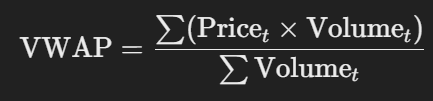

### Sentiment analysis

In [210]:
short_data.corr()

Price             Close                          High                      \
Ticker            BRK-A      TSLA     ^GSPC     BRK-A      TSLA     ^GSPC   
Price  Ticker                                                               
Close  BRK-A   1.000000 -0.863963  0.540065  0.999699 -0.864962  0.537982   
       TSLA   -0.863963  1.000000 -0.309695 -0.864623  0.999830 -0.307794   
       ^GSPC   0.540065 -0.309695  1.000000  0.538064 -0.313245  0.999601   
High   BRK-A   0.999699 -0.864623  0.538064  1.000000 -0.865514  0.536191   
       TSLA   -0.864962  0.999830 -0.313245 -0.865514  1.000000 -0.311066   
       ^GSPC   0.537982 -0.307794  0.999601  0.536191 -0.311066  1.000000   
Low    BRK-A   0.999710 -0.863376  0.541190  0.999429 -0.864452  0.539107   
       TSLA   -0.863070  0.999870 -0.307147 -0.863816  0.999755 -0.305197   
       ^GSPC   0.540997 -0.310734  0.999668  0.538972 -0.314217  0.999548   
Open   BRK-A   0.999541 -0.864179  0.539285  0.999798 -0.865132  0.537424   
       TSLA   -0.864024  0.999707 -0.310617 -0.864660  0.999857 -0.308443   
       ^GSPC   0.539010 -0.308968  0.999147  0.537187 -0.312207  0.999673   
Volume BRK-A   0.004773 -0.015913 -0.010219  0.010074 -0.013753 -0.009155   
       TSLA   -0.128149  0.133198 -0.090515 -0.118154  0.140934 -0.084690   
       ^GSPC  -0.040579 -0.006959 -0.064356 -0.033463 -0.003139 -0.057138   
ATR    BRK-A  -0.143110  0.044341 -0.286269 -0.134665  0.050852 -0.280425   
       TSLA   -0.543164  0.493817 -0.507249 -0.537695  0.501255 -0.500243   
       ^GSPC  -0.528205  0.343775 -0.743292 -0.522797  0.350404 -0.736578   

Price               Low                          Open                      \
Ticker            BRK-A      TSLA     ^GSPC     BRK-A      TSLA     ^GSPC   
Price  Ticker                                                               
Close  BRK-A   0.999710 -0.863070  0.540997  0.999541 -0.864024  0.539010   
       TSLA   -0.863376  0.999870 -0.310734 -0.864179  0.999707 -0.308968   
       ^GSPC   0.541190 -0.307147  0.999668  0.539285 -0.310617  0.999147   
High   BRK-A   0.999429 -0.863816  0.538972  0.999798 -0.864660  0.537187   
       TSLA   -0.864452  0.999755 -0.314217 -0.865132  0.999857 -0.312207   
       ^GSPC   0.539107 -0.305197  0.999548  0.537424 -0.308443  0.999673   
Low    BRK-A   1.000000 -0.862422  0.542257  0.999587 -0.863445  0.540262   
       TSLA   -0.862422  1.000000 -0.307999 -0.863313  0.999833 -0.306215   
       ^GSPC   0.542257 -0.307999  1.000000  0.540312 -0.311450  0.999595   
Open   BRK-A   0.999587 -0.863313  0.540312  1.000000 -0.864225  0.538544   
       TSLA   -0.863445  0.999833 -0.311450 -0.864225  1.000000 -0.309388   
       ^GSPC   0.540262 -0.306215  0.999595  0.538544 -0.309388  1.000000   
Volume BRK-A   0.001446 -0.017930 -0.013084  0.008351 -0.015199 -0.011135   
       TSLA   -0.135026  0.127502 -0.096854 -0.123269  0.134653 -0.090252   
       ^GSPC  -0.044329 -0.010092 -0.068427 -0.036721 -0.006750 -0.061892   
ATR    BRK-A  -0.151211  0.038273 -0.291862 -0.141354  0.044675 -0.285550   
       TSLA   -0.547679  0.487438 -0.512420 -0.542029  0.494399 -0.505344   
       ^GSPC  -0.532347  0.338440 -0.748839 -0.526678  0.344806 -0.741650   

Price            Volume                           ATR                      
Ticker            BRK-A      TSLA     ^GSPC     BRK-A      TSLA     ^GSPC  
Price  Ticker                                                              
Close  BRK-A   0.004773 -0.128149 -0.040579 -0.143110 -0.543164 -0.528205  
       TSLA   -0.015913  0.133198 -0.006959  0.044341  0.493817  0.343775  
       ^GSPC  -0.010219 -0.090515 -0.064356 -0.286269 -0.507249 -0.743292  
High   BRK-A   0.010074 -0.118154 -0.033463 -0.134665 -0.537695 -0.522797  
       TSLA   -0.013753  0.140934 -0.003139  0.050852  0.501255  0.350404  
       ^GSPC  -0.009155 -0.084690 -0.057138 -0.280425 -0.500243 -0.736578  
Low    BRK-A   0.001446 -0.135026 -0.044329 -0.151211 -0.547679 -0.532347  
    